# ENGR 240: Spline Interpolation with SciPy

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/WCC-Engineering/ENGR240/blob/main/Class%20Demos%20and%20Activities/Week%206/Worksheet%206-2%20Spline%20Interpolation%20with%20SciPy.ipynb)

## Introduction

In many engineering applications, we need to interpolate between discrete data points to create a smooth, continuous representation that approximates underlying behavior. Splines are piecewise polynomial functions that provide smooth interpolation between data points and are widely used in engineering design, data analysis, and computer graphics.

In this worksheet, we'll explore spline interpolation using SciPy's `interpolate` module, specifically focusing on cubic splines, which are among the most common types of splines used in engineering applications.

### Learning Objectives
- Understand the basic theory behind spline interpolation
- Implement various cubic spline end conditions using SciPy
- Extract and analyze spline coefficients
- Apply spline interpolation to a real engineering problem

### Application Context: Structural Beam Deflection Analysis

In this worksheet, we'll focus on a practical engineering application: analyzing the deflection of a beam under various loading conditions. Structural engineers often use spline interpolation to:

1. Smoothly interpolate between measured deflection points
2. Create continuous mathematical representations of physical measurements
3. Estimate values between measurement points
4. Generate smooth visualization of deformation profiles

The ability to properly implement various end conditions is especially important in beam analysis, as they represent different physical constraints (e.g., fixed ends, free ends, or specific known slopes).

## Theoretical Background: Spline Interpolation

### What is a Spline?

A spline is a piecewise polynomial function that smoothly connects a set of data points. The term "spline" originated from the flexible drafting tools used by shipbuilders and draftsmen to draw smooth curves through a set of points.

### Cubic Splines

Cubic splines are particularly popular because they provide a good balance between smoothness and computational efficiency. A cubic spline consists of third-degree polynomial segments connecting pairs of data points, where the polynomials are constrained to ensure the resulting curve is continuous and smooth.

For a set of data points $(x_0, y_0), (x_1, y_1), \ldots, (x_n, y_n)$ where $x_0 < x_1 < \ldots < x_n$, a cubic spline $S(x)$ is defined as:

$$S(x) = S_i(x) \quad \text{for } x_i \leq x \leq x_{i+1}, i = 0, 1, \ldots, n-1$$

where each $S_i(x)$ is a cubic polynomial of the form:

$$S_i(x) = a_i + b_i(x-x_i) + c_i(x-x_i)^2 + d_i(x-x_i)^3$$

The coefficients $a_i$, $b_i$, $c_i$, and $d_i$ are determined by enforcing the following constraints:

1. **Interpolation**: The spline passes through all data points
   - $S_i(x_i) = y_i$
   - $S_i(x_{i+1}) = y_{i+1}$
   
2. **Continuity**: The first and second derivatives are continuous at interior knots
   - $S_i'(x_{i+1}) = S_{i+1}'(x_{i+1})$
   - $S_i''(x_{i+1}) = S_{i+1}''(x_{i+1})$

### End Conditions

The constraints above give us $4n - 2$ equations for $4n$ unknown coefficients. To fully determine the spline, we need two additional conditions, typically specified at the endpoints. Common end conditions include:

1. **Natural Spline**: Second derivatives at endpoints are set to zero
   - $S''(x_0) = S''(x_n) = 0$
   
2. **Clamped Spline**: First derivatives at endpoints are specified
   - $S'(x_0) = f'_0$ and $S'(x_n) = f'_n$
   
3. **Not-a-knot**: Third derivative is continuous at the second and second-to-last points
   - $S_0'''(x_1) = S_1'''(x_1)$
   - $S_{n-2}'''(x_{n-1}) = S_{n-1}'''(x_{n-1})$
   
4. **Periodic**: Function and derivatives at endpoints match (for cyclic data)
   - $S^{(k)}(x_0) = S^{(k)}(x_n)$ for $k = 0, 1, 2$

The choice of end conditions depends on the physical constraints of the problem and the behavior expected at the boundaries.

## Setup and Imports

Let's start by importing the necessary libraries:

In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

## Task 1: Basic Spline Interpolation

Let's start with a simple example of beam deflection data. Consider a simply-supported beam with a concentrated load at its center. We have measured the deflection at several points along the beam:

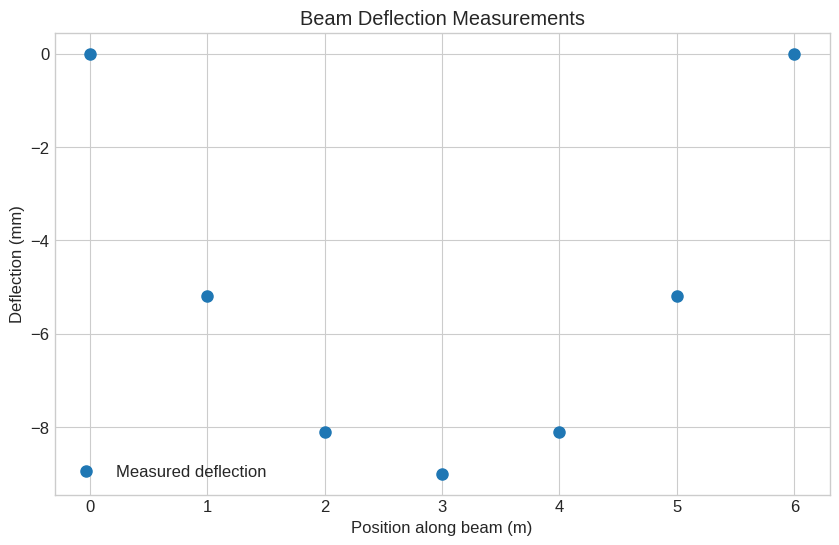

In [2]:
# Define beam data
# x represents position along the beam (meters)
# y represents measured deflection (millimeters)
x = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
y = np.array([0.0, -5.2, -8.1, -9.0, -8.1, -5.2, 0.0])

# Plot the measured data points
plt.figure()
plt.plot(x, y, 'o', markersize=8, label='Measured deflection')
plt.xlabel('Position along beam (m)')
plt.ylabel('Deflection (mm)')
plt.title('Beam Deflection Measurements')
plt.grid(True)
plt.legend()
plt.show()

### Step 1: Create a Basic Cubic Spline

Let's create a basic cubic spline interpolation using SciPy's `CubicSpline` function with default settings (natural spline):

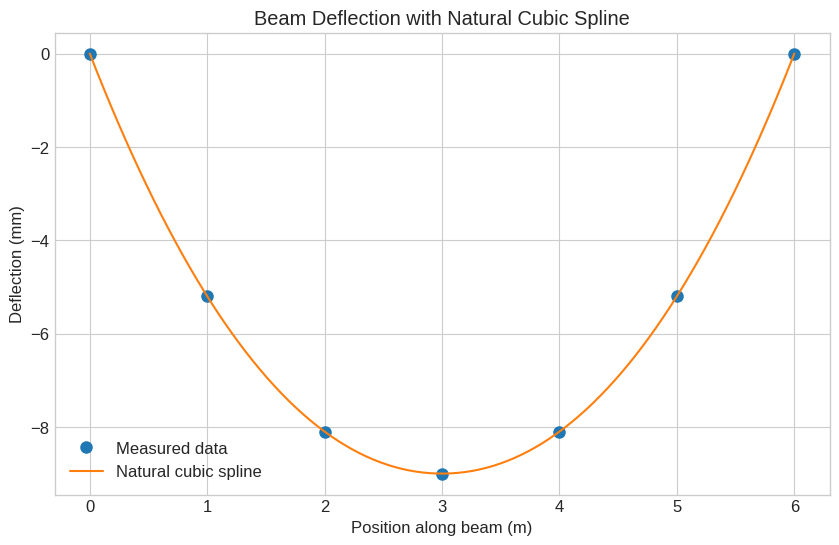

In [3]:
# Create a cubic spline with default settings (natural spline)
cs_natural = interpolate.CubicSpline(x, y)

# Create a finer grid for smooth plotting
x_fine = np.linspace(0, 6, 200)
y_natural = cs_natural(x_fine)

# Plot the results
plt.figure()
plt.plot(x, y, 'o', markersize=8, label='Measured data')
plt.plot(x_fine, y_natural, '-', label='Natural cubic spline')
plt.xlabel('Position along beam (m)')
plt.ylabel('Deflection (mm)')
plt.title('Beam Deflection with Natural Cubic Spline')
plt.legend()
plt.grid(True)
plt.show()

### Step 2: Examine the Spline Coefficients

The `CubicSpline` object contains the coefficients for each polynomial segment. Let's extract and examine these coefficients:

In [4]:
# Display the coefficients of the natural cubic spline
print("Cubic Spline Coefficients:")
print("\nCoefficients shape:", cs_natural.c.shape)
print("\nCoefficient array:\n", cs_natural.c)
print("\nKnots (x values):\n", cs_natural.x)

# Print coefficients for each segment in a more readable format
print("\nCoefficients for each polynomial segment:")
for i in range(len(x) - 1):
    print(f"\nSegment {i} ({x[i]} ≤ x ≤ {x[i+1]})")
    # Note: SciPy's CubicSpline stores coefficients in the order [d, c, b, a] for each segment
    # The polynomials are of the form: a + b(x-x_i) + c(x-x_i)^2 + d(x-x_i)^3
    a = cs_natural(x[i])  # The value at the left endpoint is the constant term
    b = cs_natural.c[2, i]
    c = cs_natural.c[1, i]
    d = cs_natural.c[0, i]
    print(f"  P{i}(x) = {a:.4f} + {b:.4f}(x-{x[i]}) + {c:.4f}(x-{x[i]})^2 + {d:.4f}(x-{x[i]})^3")

Cubic Spline Coefficients:

Coefficients shape: (4, 6)

Coefficient array:
 [[-5.00000000e-02 -5.00000000e-02 -5.00000000e-02  5.00000000e-02
   5.00000000e-02  5.00000000e-02]
 [ 1.30000000e+00  1.15000000e+00  1.00000000e+00  8.50000000e-01
   1.00000000e+00  1.15000000e+00]
 [-6.45000000e+00 -4.00000000e+00 -1.85000000e+00 -5.97812398e-17
   1.85000000e+00  4.00000000e+00]
 [ 0.00000000e+00 -5.20000000e+00 -8.10000000e+00 -9.00000000e+00
  -8.10000000e+00 -5.20000000e+00]]

Knots (x values):
 [0. 1. 2. 3. 4. 5. 6.]

Coefficients for each polynomial segment:

Segment 0 (0.0 ≤ x ≤ 1.0)
  P0(x) = 0.0000 + -6.4500(x-0.0) + 1.3000(x-0.0)^2 + -0.0500(x-0.0)^3

Segment 1 (1.0 ≤ x ≤ 2.0)
  P1(x) = -5.2000 + -4.0000(x-1.0) + 1.1500(x-1.0)^2 + -0.0500(x-1.0)^3

Segment 2 (2.0 ≤ x ≤ 3.0)
  P2(x) = -8.1000 + -1.8500(x-2.0) + 1.0000(x-2.0)^2 + -0.0500(x-2.0)^3

Segment 3 (3.0 ≤ x ≤ 4.0)
  P3(x) = -9.0000 + -0.0000(x-3.0) + 0.8500(x-3.0)^2 + 0.0500(x-3.0)^3

Segment 4 (4.0 ≤ x ≤ 5.0)
  P4(x) = -8

### Step 3: Understanding the Coefficient Array

The coefficient array returned by SciPy's `CubicSpline` is organized as follows:
- Shape: (4, n-1) where n is the number of data points
- Row 0: Coefficients for the cubic term (d)
- Row 1: Coefficients for the quadratic term (c)
- Row 2: Coefficients for the linear term (b)
- Row 3: Coefficients for the constant term (not used directly, as each polynomial is defined relative to the left knot)

For a given segment i (between knots i and i+1), the polynomial is:
P_i(x) = a_i + b_i(x-x_i) + c_i(x-x_i)^2 + d_i(x-x_i)^3

where:
- a_i = y_i (the value at the left knot)
- b_i = cs.c[2, i]
- c_i = cs.c[1, i]
- d_i = cs.c[0, i]


## Task 2: Implementing Different End Conditions

Now, let's explore how different end conditions affect the spline interpolation. The SciPy `CubicSpline` function allows us to specify various boundary conditions using the `bc_type` parameter.

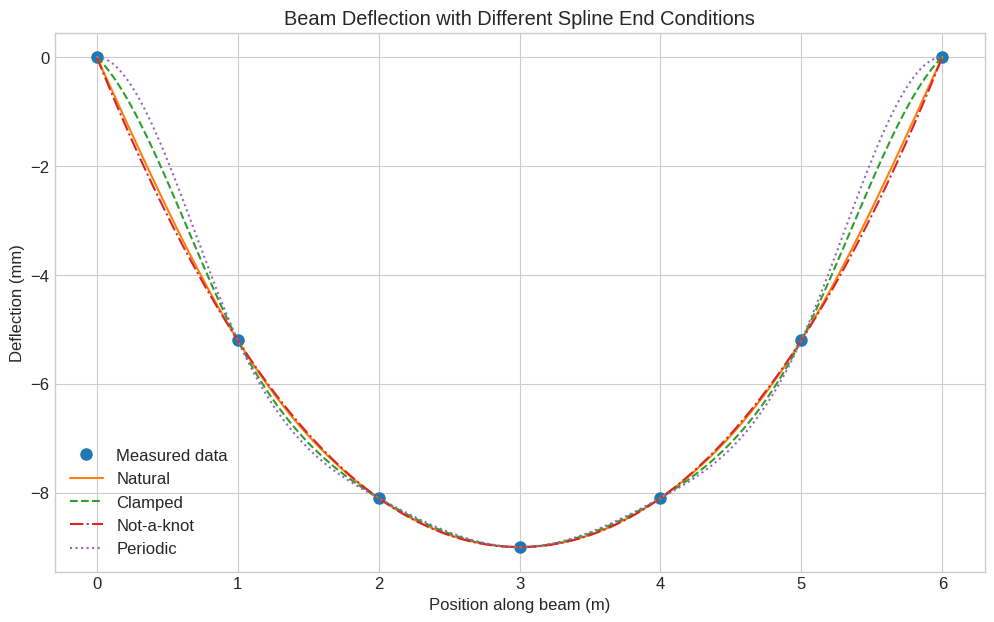

In [5]:
# Create cubic splines with different end conditions

# 1. Natural spline (second derivatives at endpoints are zero)
cs_natural = interpolate.CubicSpline(x, y, bc_type='natural')

# 2. Clamped spline (first derivatives specified at endpoints)
# For a simply supported beam, the slope at the supports should be non-zero
# Let's specify slopes based on theoretical beam deflection
cs_clamped = interpolate.CubicSpline(x, y, bc_type=((1, -2.5), (1, 2.5)))  # (left_bc, right_bc)

# 3. Not-a-knot condition
cs_notaknot = interpolate.CubicSpline(x, y, bc_type='not-a-knot')

# 4. Periodic condition (not suitable for this beam problem but included for completeness)
# Note: This would only work if y[0] = y[-1], which is true for our beam
cs_periodic = interpolate.CubicSpline(x, y, bc_type='periodic')

# Evaluate the splines on a fine grid
y_natural = cs_natural(x_fine)
y_clamped = cs_clamped(x_fine)
y_notaknot = cs_notaknot(x_fine)
y_periodic = cs_periodic(x_fine)

# Plot the results
plt.figure(figsize=(12, 7))
plt.plot(x, y, 'o', markersize=8, label='Measured data')
plt.plot(x_fine, y_natural, '-', label='Natural')
plt.plot(x_fine, y_clamped, '--', label='Clamped')
plt.plot(x_fine, y_notaknot, '-.', label='Not-a-knot')
plt.plot(x_fine, y_periodic, ':', label='Periodic')
plt.xlabel('Position along beam (m)')
plt.ylabel('Deflection (mm)')
plt.title('Beam Deflection with Different Spline End Conditions')
plt.legend()
plt.grid(True)
plt.show()

### Let's also examine the first derivatives (slope) of these splines

The first derivative of the deflection curve represents the slope of the beam. For a simply-supported beam, we expect non-zero slopes at the supports. Let's visualize how different end conditions affect the slope:

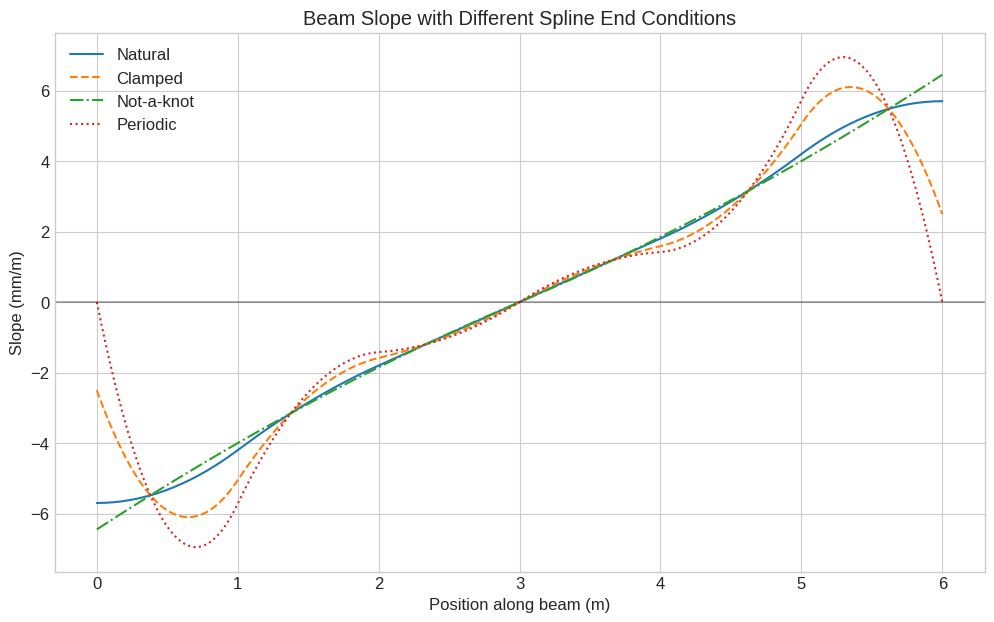

In [6]:
# Calculate the first derivatives of the splines
y_natural_deriv = cs_natural(x_fine, 1)  # 1 indicates first derivative
y_clamped_deriv = cs_clamped(x_fine, 1)
y_notaknot_deriv = cs_notaknot(x_fine, 1)
y_periodic_deriv = cs_periodic(x_fine, 1)

# Plot the first derivatives
plt.figure(figsize=(12, 7))
plt.plot(x_fine, y_natural_deriv, '-', label='Natural')
plt.plot(x_fine, y_clamped_deriv, '--', label='Clamped')
plt.plot(x_fine, y_notaknot_deriv, '-.', label='Not-a-knot')
plt.plot(x_fine, y_periodic_deriv, ':', label='Periodic')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('Position along beam (m)')
plt.ylabel('Slope (mm/m)')
plt.title('Beam Slope with Different Spline End Conditions')
plt.legend()
plt.grid(True)
plt.show()

## Task 3: Custom End Conditions

Now, let's implement custom end conditions for our spline. For a simply-supported beam, we know that:
1. The deflection at the supports is zero (already in our data)
2. The second derivative (curvature) is proportional to the bending moment

Let's implement a clamped condition with different slopes on each end:

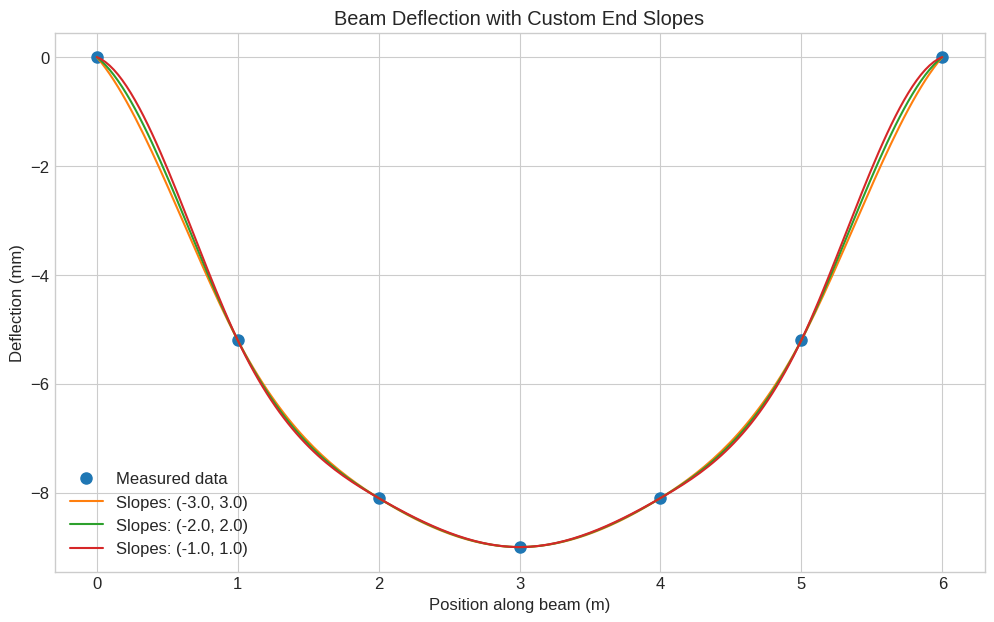

In [7]:
# Experiment with different slope values at the endpoints
left_slopes = [-3.0, -2.0, -1.0]
right_slopes = [3.0, 2.0, 1.0]

plt.figure(figsize=(12, 7))
plt.plot(x, y, 'o', markersize=8, label='Measured data')

# Try different combinations of slopes
for i, (left_slope, right_slope) in enumerate(zip(left_slopes, right_slopes)):
    cs_custom = interpolate.CubicSpline(x, y, bc_type=((1, left_slope), (1, right_slope)))
    y_custom = cs_custom(x_fine)
    plt.plot(x_fine, y_custom, '-',
             label=f'Slopes: ({left_slope}, {right_slope})')

plt.xlabel('Position along beam (m)')
plt.ylabel('Deflection (mm)')
plt.title('Beam Deflection with Custom End Slopes')
plt.legend()
plt.grid(True)
plt.show()

Now, let's implement a mixed boundary condition, where we specify different types of constraints on each end:

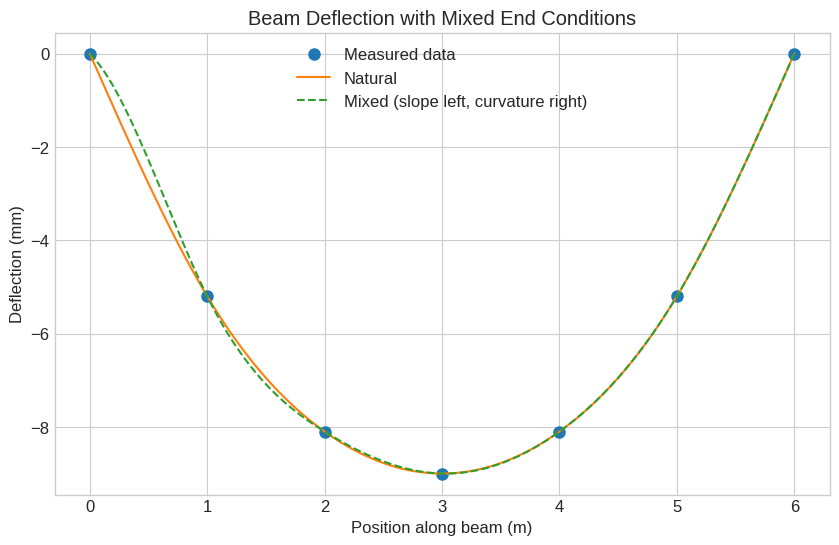

In [8]:
# Mixed boundary conditions
# Left end: First derivative (slope) specified
# Right end: Second derivative (curvature) specified
cs_mixed = interpolate.CubicSpline(x, y, bc_type=((1, -2.5), (2, 0)))

# Evaluate the spline on a fine grid
y_mixed = cs_mixed(x_fine)

# Plot the results
plt.figure()
plt.plot(x, y, 'o', markersize=8, label='Measured data')
plt.plot(x_fine, y_natural, '-', label='Natural')
plt.plot(x_fine, y_mixed, '--', label='Mixed (slope left, curvature right)')
plt.xlabel('Position along beam (m)')
plt.ylabel('Deflection (mm)')
plt.title('Beam Deflection with Mixed End Conditions')
plt.legend()
plt.grid(True)
plt.show()

## Task 4: Extracting and Examining Spline Coefficients

Now let's create a function to display the coefficients in a more readable format:

In [9]:
def display_spline_coefficients(spline, x_values):
    """Display the coefficients of a cubic spline in a readable format.

    Parameters:
    -----------
    spline : scipy.interpolate.CubicSpline
        The cubic spline object
    x_values : array-like
        The x coordinates of the data points (knots)
    """
    print("Spline Coefficients:")
    print(f"  Number of segments: {len(x_values) - 1}")
    print(f"  Coefficient array shape: {spline.c.shape}")
    print("\nPolynomial representation for each segment:")

    for i in range(len(x_values) - 1):
        x_i = x_values[i]
        x_i1 = x_values[i+1]
        print(f"\nSegment {i}: {x_i} ≤ x ≤ {x_i1}")

        # Extract coefficients for this segment
        # In SciPy's CubicSpline, coefficients are stored as [d, c, b, a]
        a = spline(x_i)  # Value at left knot
        b = spline.c[2, i]  # Linear coefficient
        c = spline.c[1, i]  # Quadratic coefficient
        d = spline.c[0, i]  # Cubic coefficient

        # Print the polynomial
        equation = f"  P{i}(x) = {a:.6f}"
        if b != 0:
            equation += f" + {b:.6f}(x-{x_i})"
        if c != 0:
            equation += f" + {c:.6f}(x-{x_i})²"
        if d != 0:
            equation += f" + {d:.6f}(x-{x_i})³"
        print(equation)

    return

# Display coefficients for the natural spline
print("Natural Spline:")
display_spline_coefficients(cs_natural, x)

# Display coefficients for the clamped spline
print("\n" + "-"*50 + "\n")
print("Clamped Spline:")
display_spline_coefficients(cs_clamped, x)

Natural Spline:
Spline Coefficients:
  Number of segments: 6
  Coefficient array shape: (4, 6)

Polynomial representation for each segment:

Segment 0: 0.0 ≤ x ≤ 1.0
  P0(x) = 0.000000 + -5.700000(x-0.0) + -0.000000(x-0.0)² + 0.500000(x-0.0)³

Segment 1: 1.0 ≤ x ≤ 2.0
  P1(x) = -5.200000 + -4.200000(x-1.0) + 1.500000(x-1.0)² + -0.200000(x-1.0)³

Segment 2: 2.0 ≤ x ≤ 3.0
  P2(x) = -8.100000 + -1.800000(x-2.0) + 0.900000(x-2.0)² + 0.000000(x-2.0)³

Segment 3: 3.0 ≤ x ≤ 4.0
  P3(x) = -9.000000 + 0.000000(x-3.0) + 0.900000(x-3.0)² + -0.000000(x-3.0)³

Segment 4: 4.0 ≤ x ≤ 5.0
  P4(x) = -8.100000 + 1.800000(x-4.0) + 0.900000(x-4.0)² + 0.200000(x-4.0)³

Segment 5: 5.0 ≤ x ≤ 6.0
  P5(x) = -5.200000 + 4.200000(x-5.0) + 1.500000(x-5.0)² + -0.500000(x-5.0)³

--------------------------------------------------

Clamped Spline:
Spline Coefficients:
  Number of segments: 6
  Coefficient array shape: (4, 6)

Polynomial representation for each segment:

Segment 0: 0.0 ≤ x ≤ 1.0
  P0(x) = 0.000000 + -2

## Task 5: Student Practice - Implementing a Custom Spline

Now it's your turn to work with splines! Consider a new engineering scenario: a bridge girder with the following measured deflection data:

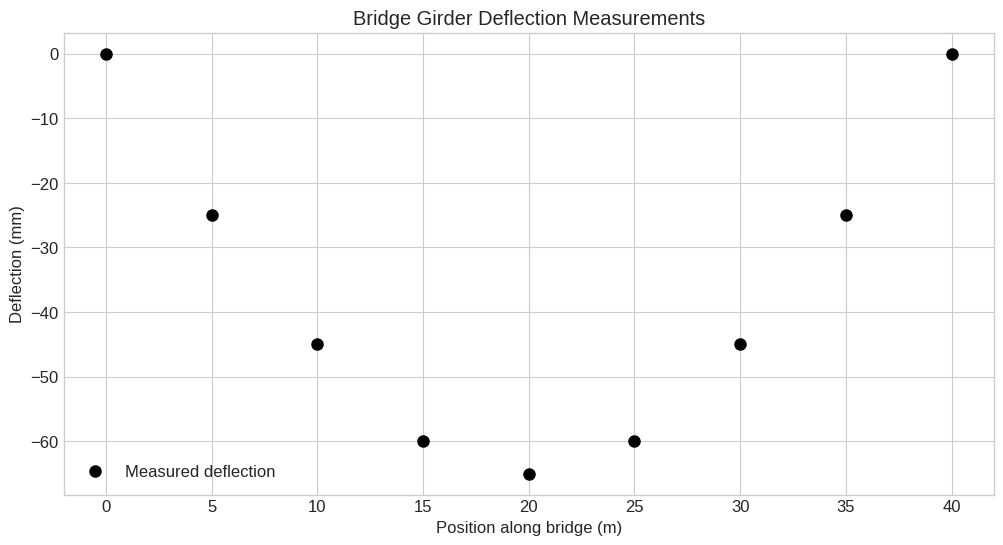

In [10]:
# Bridge girder data
bridge_x = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40])  # Position (m)
bridge_y = np.array([0, -25, -45, -60, -65, -60, -45, -25, 0])  # Deflection (mm)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(bridge_x, bridge_y, 'ko', markersize=8, label='Measured deflection')
plt.xlabel('Position along bridge (m)')
plt.ylabel('Deflection (mm)')
plt.title('Bridge Girder Deflection Measurements')
plt.grid(True)
plt.legend()
plt.show()

### Your Task: Create a Cubic Spline with Custom End Conditions

1. Create a cubic spline for the bridge data using the 'natural' end condition
2. Create another spline with custom end slopes: left slope = -8, right slope = 8
3. Create a third spline using the 'not-a-knot' condition
4. Plot all three splines on the same graph for comparison
5. Extract and print the coefficients for the segment between x=15 and x=20

**Note**: Remember that the syntax for specifying a clamped spline is: `bc_type=((1, left_slope), (1, right_slope))`

In [ ]:
# Your code here
# 1. Create splines with different end conditions

# 2. Plot the splines

# 3. Find and print coefficients for the segment between x=15 and x=20

## Task 6: Discussion Questions

After completing the above tasks, answer the following questions:

1. How do the different end conditions affect the behavior of the spline near the endpoints? Which end condition seems most appropriate for the bridge girder deflection problem?

2. When examining the coefficients for the different splines, what differences do you notice?

3. In which engineering scenarios would you prefer to use a natural spline versus a clamped spline?

4. What are the advantages and disadvantages of spline interpolation compared to other interpolation methods (like polynomial interpolation)?

Your answers here:

1.

2.

3.

4.

## Conclusion

In this worksheet, we've explored the fundamentals of cubic spline interpolation using SciPy. We've learned how to:

1. Create cubic splines with various end conditions
2. Visualize the resulting interpolations
3. Extract and understand the spline coefficients
4. Apply splines to engineering problems like beam deflection analysis

Spline interpolation is a powerful tool for engineering applications where smooth interpolation of measured data is essential. By understanding how to work with end conditions and coefficients, you can create accurate and physically meaningful interpolations.